# Step1. 인물모드 직접 해 보기

selfie*인 파일을 불러오기 위해 glob 패키지 추가

In [1]:
# glob: 파일들 중 패턴과 일치하는 파일들의 리스트 반환
# os: Operating System의 줄임말로, 운영체제에서 제공되는 여러 기능을 파이썬에서 사용할 수 있도록 함 (Ex. 디렉토리 경로 이동, 시스템 환경 변수 가져오기 등)
# urllib: URL 작업을 위한 여러 모듈을 모은 패키지. (Ex. urllib.request, urllib.parse, ...)
# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# pixellib: 이미지 및 비디오 segmentation을 수행하기 위한 라이브러리. 
# pixellib.semantic: segmentation 기법 중, semantic segmentation을 쉽게 사용할 수 있도록 만든 라이브러리
# matplotlib: 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구
import glob
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

## 사진 준비

(2160, 2880, 3)


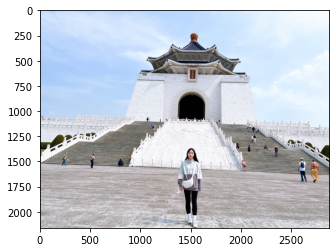

(2436, 1125, 3)


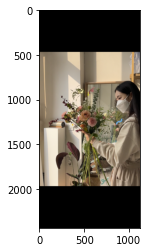

(3840, 2160, 3)


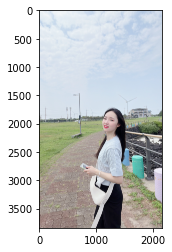

In [2]:
# os 모듈에 있는 getenv() 함수를 이용하여 읽고싶은 파일의 경로를 file_path에 저장
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장
img_dir = '/aiffel/aiffel/human_segmentation/images/'
img_paths = glob.glob(os.path.join(img_dir, 'selfie*'))

for img_path in img_paths:
    img_orig = cv2.imread(img_path)
    print(img_orig.shape)
    
    # cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
    # cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
    # plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
    # plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.show()

## 세그멘테이션으로 사람 분리

모델 다운로드

In [3]:
# 저장할 파일 이름을 결정합니다
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. model_dir 에 "/aiffel/human_segmentation/models" 저장
# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장
# 1
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7dd2add84700>)

세그멘테이션 모델 생성

In [4]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

인물모드 함수 생성<br>
3개의 이미지에 적용해야 하므로 함수로 생성함.

In [5]:
def portrait_mode(model, img_path, target_obj, blur_ksize = (13, 13)):
    # 이미지 불러오기
    img_orig = cv2.imread(img_path)
    
    # 불러온 이미지 분할, 분할 출력 배열 생성
    segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용
    
    # object 추출
    LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]
    try:
        obj_idx = LABEL_NAMES.index(target_obj)
    except ValueError:
        return LABEL_NAMES
    
    # 아래 코드를 이해하지 않아도 좋습니다
    # PixelLib에서 그대로 가져온 코드입니다
    # 주목해야 할 것은 생상 코드 결과물이예요!

    #컬러맵 만들기 
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
    
    # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서
    seg_color = (colormap[obj_idx][2], colormap[obj_idx][1], colormap[obj_idx][0])
    
    # seg_color로만 이루어진 마스크
    # output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
    # seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
    # cmap 값을 변경하면 다른 색상으로 확인이 가능함
    seg_map = np.all(output==seg_color, axis=-1)
    
    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255
    
    # 배경 흐리게 하기
    # (13,13)은 blurring kernel size를 뜻합니다
    # 다양하게 바꿔보세요
    img_orig_blur = cv2.blur(img_orig, blur_ksize)
    
    # 세그멘테이션 마스크를 이용해서 배경만 추출
    # cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
    # cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
    # 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    # cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
    # 연산을 하고 나면 배경은 255 사람은 0입니다.
    img_bg_mask = cv2.bitwise_not(img_mask_color)

    # cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
    # 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
    # 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    
    # np.where(조건, 참일때, 거짓일때)
    # 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
    # 아닌 영역은 블러된 이미지 값을 사용합니다.
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    
    return img_concat

In [6]:
def chromakey_mode(model, img_path, bg_path, target_obj, blur_ksize = (13, 13)):
    # 이미지 불러오기
    img_orig = cv2.imread(img_path)
    
    # 불러온 이미지 분할, 분할 출력 배열 생성
    segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용
    
    # object 추출
    LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]
    try:
        obj_idx = LABEL_NAMES.index(target_obj)
    except ValueError:
        return LABEL_NAMES
    
    # 아래 코드를 이해하지 않아도 좋습니다
    # PixelLib에서 그대로 가져온 코드입니다
    # 주목해야 할 것은 생상 코드 결과물이예요!

    #컬러맵 만들기 
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
    
    # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서
    seg_color = (colormap[obj_idx][2], colormap[obj_idx][1], colormap[obj_idx][0])
    
    # seg_color로만 이루어진 마스크
    # output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
    # seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
    # cmap 값을 변경하면 다른 색상으로 확인이 가능함
    seg_map = np.all(output==seg_color, axis=-1)
    
    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255
    
    # 배경 불러오기
    img_bg = cv2.imread(bg_path)
    img_bg = cv2.resize(img_bg, (img_orig.shape[1], img_orig.shape[0]))
    
    # 세그멘테이션 마스크를 이용해서 배경만 추출
    # cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
    # cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
    # 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    
    # cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
    # 연산을 하고 나면 배경은 255 사람은 0입니다.
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    
    # cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
    # 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
    # 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
    img_bg_chromakey = cv2.bitwise_and(img_bg, img_bg_mask)
    
    # np.where(조건, 참일때, 거짓일때)
    # 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
    # 아닌 영역은 블러된 이미지 값을 사용합니다.
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_chromakey)
    
    return img_concat

이미지 적용

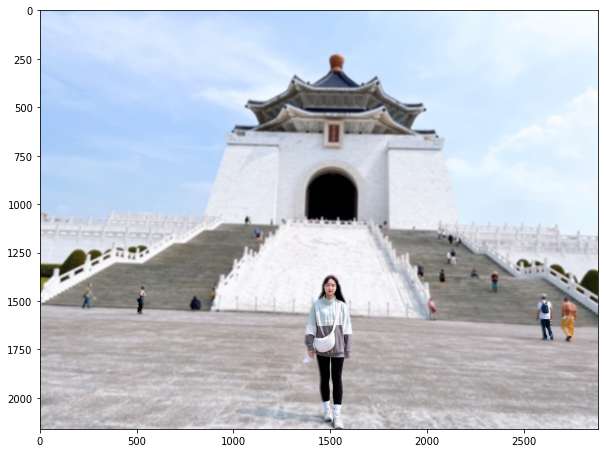

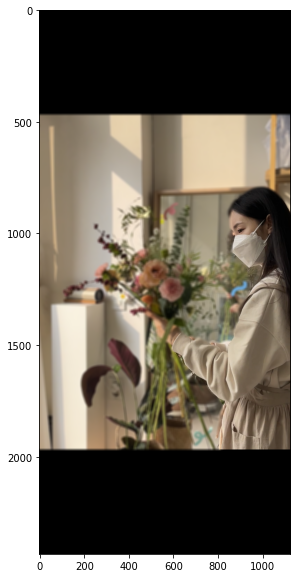

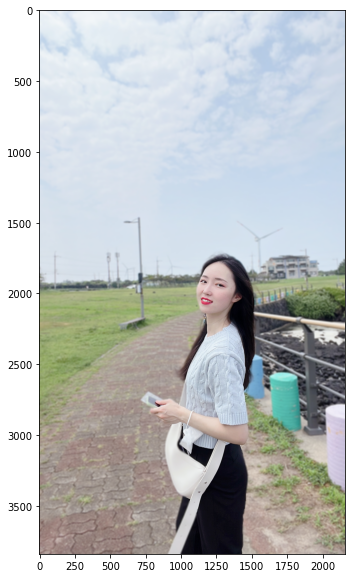

In [7]:
for img_path in img_paths:
    img_concat = portrait_mode(model, img_path, 'person')
    plt.figure(figsize = (10, 10))
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

동물 이미지 적용

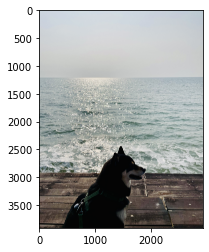

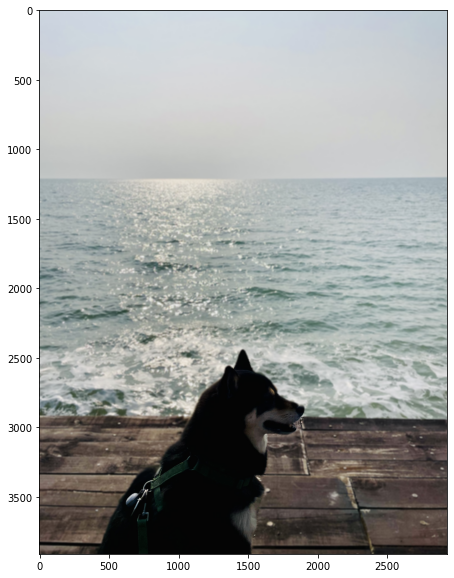

In [8]:
img_path = os.path.join(img_dir, 'shiba.png')
# 이미지 확인
img_orig = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 블러 처리
img_concat = portrait_mode(model, img_path, 'dog')
plt.figure(figsize = (10, 10))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

크로마키 적용

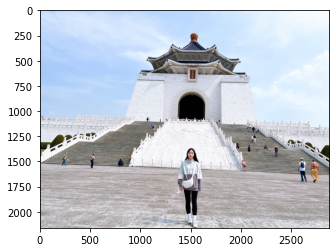

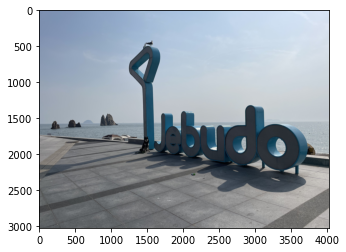

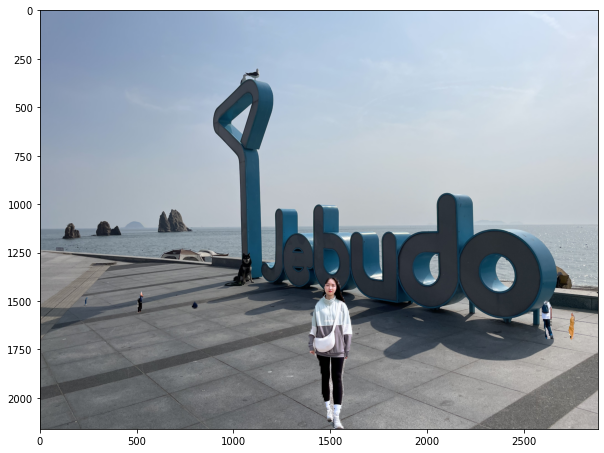

In [9]:
img_path = img_paths[0]
bg_path = os.path.join(img_dir, 'background.png')

# 이미지 확인
img_orig = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()
bg_orig = cv2.imread(bg_path)
plt.imshow(cv2.cvtColor(bg_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 블러 처리
img_concat = chromakey_mode(model, img_path, bg_path, 'person')
plt.figure(figsize = (10, 10))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# Step2. 사진에서 문제점 찾기
- 관심있는 사람이 아닌 다른 사람도 블러처리가 되지 않음.
- 꽃다발을 잡고 있는 손이 블러처리됨.
- 경계 부분에서 블러되지 않아야 하는 곳이 블러되기도 함.(머리카락 등)
- 큰(픽셀이 많은) 이미지는 블러처리가 되어도 원본 이미지와 크게 차이나지 않음.
- 크로마키가 어색함.

# Step3. 해결 방법 제안해 보기
DeepLap 모델의 Semantic Segmentation이 만들어낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지 메커니즘이 포함된 솔루션
## 세그멘테이션의 한계
Sementic segmentation의 부정확성이 문제를 일으키는 주요 원인.<br>
피사계심도를 이용한 아웃포커싱 효과는 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별<br>
semantic segmentation 모듈은 정확도가 1.00이 되지 않는 한 완벽히 구현하기 힘듦.
https://m.blog.naver.com/typs6301/222172333739<br>
https://www.adobe.com/kr/creativecloud/photography/discover/shallow-depth-of-field.html<br>
## 3D Camera 활용하기
스테레오 비전, ToF 방식 등이 자주 사용.<br>
https://news.skhynix.co.kr/post/next-gen-3d<br>
## 소프트웨어 기술 활용하기
구글의 struct2Depth가 대표적<br>
https://sites.google.com/view/struct2depth<br>
## 다른 기술과 융합해 보기
구글의 pixel4에는 IR(적외선) 카메라가 있음. 이를 통해 3d depth sensing이 가능함.<br>
https://ai.googleblog.com/2020/04/udepth-real-time-3d-depth-sensing-on.html<br>

## 사진에서 문제점 해결 방법

### 관심있는 사람이 아닌 다른 사람도 블러처리가 되지 않음.
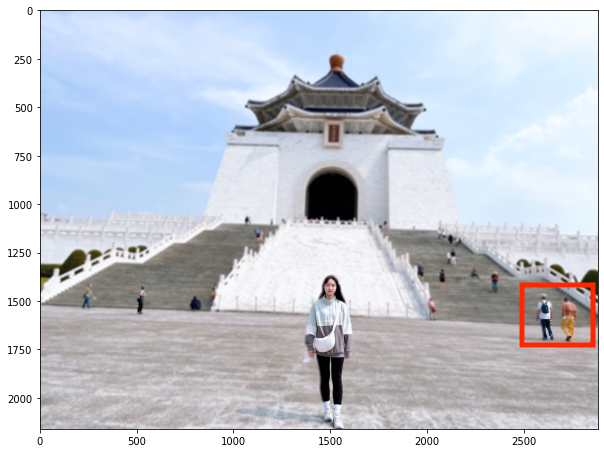<br>
얼굴 감지(face detection)나 전심 감지 기술을 사용하여 관심있는 사람의 얼굴을 식별하고, 이를 토대로 관심 있는 영역을 제외한 나머지를 블러 처리할 수 있을 것같음.<br>
얼굴 감지를 이용한 관심있는 사람 제외 모두 블러<br>
먼저, 얼굴 감지를 통해 내가 관심있는 얼굴인지 확인하는 코드가 필요함. 내가 관심 있는 얼굴의 (x, y)좌표를 얻음.<br>
원본 이미지와 같은 크기의 array를 생성(np.zero 사용). 박스 내의 개체를 2로 변경.<br>
img_mask + face_array를 하면, 얼굴 영역은 3, 얼굴 박스 내 + 얼굴 영역 외 부분은 2, 얼굴이 아닌 몸은 1의 값을 가짐.<br>
3을 0으로 바꾸고, 2를 1로 바꾸면 새로운 img_mask가 생성됨. 해당 img_mask를 이용해 블러처리.

### 꽃다발을 잡고 있는 손이 블러처리됨.
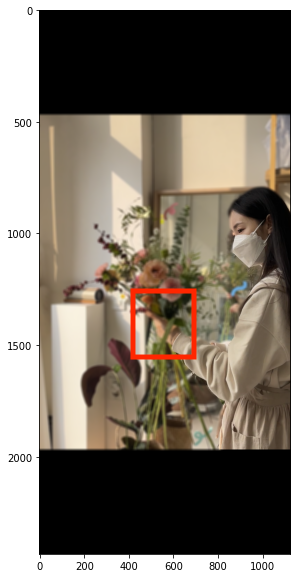<br>
깊이 추청 알고리즘을 이용해 사진 내의 깊이를 추정함.<br>
추정된 깊이를 이용해서 깊이 값이 사람에 해당하는 영역을 식별하는 알고리즘을 구현함.<br>
검출된 영역을 기준으로 깊이 맵에서 해당 영역을 제외하여 블러 처리를 적용하지 않을 영역을 설정함.<br>
셸로우 포커스 적용.

### 큰(픽셀이 많은) 이미지는 블러처리가 되어도 원본 이미지와 크게 차이나지 않음.
cv2.blur에서 blurring kernel size를 크게 하면 더 많은 픽셀이 kernel에 들어가게 되어서 더 강한 블러효과를 낼 수 있음.

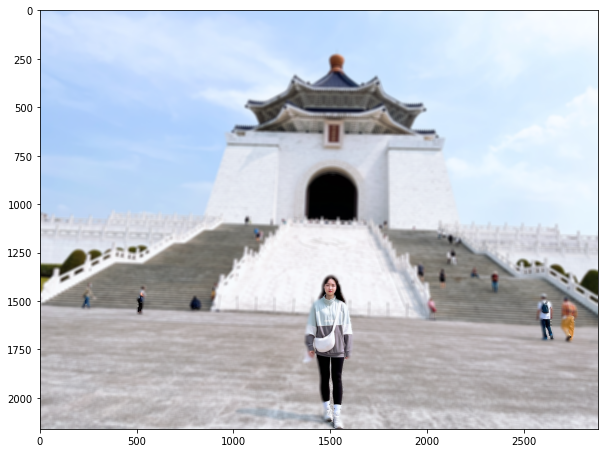

In [10]:
# blur kernel size를 키웠을 때
img_concat = portrait_mode(model, img_paths[0], 'person', (17, 17))
plt.figure(figsize = (10, 10))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 크로마키가 어색함.
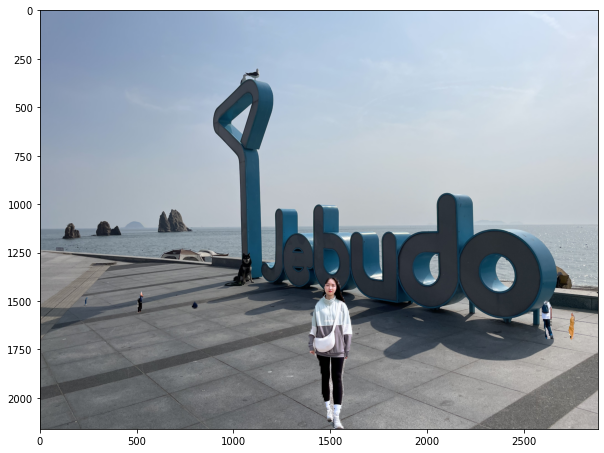<br>
색상의 차이를 비슷하게 맞춰주면 될 것같음.

# 회고

portrait_mode 함수를 정의하면서 target_obj이 LABEL_NAMES에 없을 때 LABEL_NAMES를 return하였음.<br>
하지만 portrait_mode는 plt.imshow와 자주 사용되므로<br>
print(LABEL_NAMES)<br>
return <br>
과 같이 return 전에 LABEL_NAMES를 출력하는 코드를 넣는 것도 좋을 것같음.

크로마키가 루브릭에 들어가는 걸 늦게 발견해서 함수를 나눠서 구현하였음. 함수를 나눠서 구현하는 것보다는, 크로마키 적용 flag를 하나 두고, if 문으로 크로마키적용할지, 셸로우 포커스를 적용할지 선택하는게 더 좋을 것같음.

크로마키를 할 때 배경이미지를 원본 이미지에 맞춰 resize하였음. resize보다는 두 이미지를 같은 사이즈로 crop하는 것이 더 자연스러운 이미지를 만들 수 있을 것같음.